In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Scikit-learn imports
from sklearn.metrics import (
    confusion_matrix, auc, roc_curve, roc_auc_score, 
    classification_report, ConfusionMatrixDisplay, 
    RocCurveDisplay, accuracy_score, precision_score, 
    recall_score, f1_score, make_scorer, precision_recall_curve, PrecisionRecallDisplay
)

from sklearn.model_selection import (
    train_test_split
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.utils import compute_sample_weight
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin


# Set max columns and rows to display
pd.set_option('display.max_columns', 500)

# Ignore warnings
warnings.filterwarnings('ignore')


In [2]:
csv_file_path = os.path.join('..', 'data', 'two-years-recid.csv')

df = pd.read_csv(csv_file_path)

print(df.shape)
df.head()

(6114, 35)


,id,name,sex,dob,age,race,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,juv_fel_count,juv_misd_count,juv_other_count,priors_count,compas_screening_date,type_of_assessment,decile_score,score_text,v_type_of_assessment,v_decile_score,v_score_text,is_recid,r_case_number,r_offense_date,r_charge_degree,r_charge_desc,is_violent_recid,vr_case_number,vr_offense_date,vr_charge_degree,vr_charge_desc,two_year_recid
0,1,steven lux,Male,1953-06-15,62,Caucasian,2013-01-05 04:35:31,2013-01-07 03:18:03,13000208CF10A,2013-01-05,NaN,F,False Imprisonment,0,0,0,0,2013-01-05,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
1,2,andre small,Male,1987-10-01,28,African-American,2013-04-02 12:18:46,2013-04-04 07:54:22,13006354MM10A,2013-04-02,NaN,M,Battery,0,0,0,1,2013-04-03,Risk of Recidivism,3,Low,Risk of Violence,3,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,3,willie gray,Male,1959-01-12,57,African-American,2014-10-31 12:02:01,2014-10-31 01:47:05,14040148MU10A,2014-10-30,NaN,M,DUI Level 0.15 Or Minor In Veh,0,0,0,8,2014-10-31,Risk of Recidivism,4,Low,Risk of Violence,2,Low,1,15043364TC20A,2015-07-23,(M2),Driving License Suspended,0,NaN,NaN,NaN,NaN,1
3,4,nickson marcellus,Male,1996-07-11,19,African-American,2014-01-23 03:19:30,2014-01-23 01:04:34,13017969CF10A,NaN,2014-01-23,F,arrest case no charge,0,1,0,1,2014-01-23,Risk of Recidivism,10,High,Risk of Violence,10,High,1,16000241MM20A,2016-01-04,(M1),Possess Cannabis/20 Grams Or Less,0,NaN,NaN,NaN,NaN,1
4,5,patria barnes,Female,1978-06-06,37,Other,2013-12-08 01:55:28,2013-12-09 02:00:59,13022717MM10A,2013-12-07,NaN,M,Battery,0,0,0,0,2013-12-09,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


In [3]:
selected_columns = [
            "id", "name", "sex", "dob", "race",
            "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count",
            "c_case_number", "c_charge_degree", "c_charge_desc", "c_offense_date",
            "c_arrest_date", "c_jail_in", "is_recid"]

df = df.copy()[selected_columns]

df.head()

,id,name,sex,dob,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_case_number,c_charge_degree,c_charge_desc,c_offense_date,c_arrest_date,c_jail_in,is_recid
0,1,steven lux,Male,1953-06-15,Caucasian,0,0,0,0,13000208CF10A,F,False Imprisonment,2013-01-05,NaN,2013-01-05 04:35:31,0
1,2,andre small,Male,1987-10-01,African-American,0,0,0,1,13006354MM10A,M,Battery,2013-04-02,NaN,2013-04-02 12:18:46,0
2,3,willie gray,Male,1959-01-12,African-American,0,0,0,8,14040148MU10A,M,DUI Level 0.15 Or Minor In Veh,2014-10-30,NaN,2014-10-31 12:02:01,1
3,4,nickson marcellus,Male,1996-07-11,African-American,0,1,0,1,13017969CF10A,F,arrest case no charge,NaN,2014-01-23,2014-01-23 03:19:30,1
4,5,patria barnes,Female,1978-06-06,Other,0,0,0,0,13022717MM10A,M,Battery,2013-12-07,NaN,2013-12-08 01:55:28,0


# Baseline Pipeline

In [4]:
class FeatureCreation(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.selected_columns = [
            "id", "name", "sex", "dob", "race",
            "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count",
            "c_case_number", "c_charge_degree", "c_charge_desc", "c_offense_date",
            "c_arrest_date", "c_jail_in"
        ]
    
    def fit(self, X, y=None):
        # This method doesn't need to do anything for this transformer
        return self
    
    def transform(self, X):
        # Make a copy of the dataframe to avoid modifying the original input
        df = X.copy()
        
        # Convert dates to datetime
        df['dob'] = pd.to_datetime(df['dob'])
        df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])

        # Age Calculation as an integer
        df['age_at_arrest'] = (df['c_jail_in'] - df['dob']).dt.days // 365

        # Age group
        age_bins = [0, 24, 34, 44, 54, 100]
        age_labels = ['<25', '25-34', '35-44', '45-54', '55+']
        df['age_group'] = pd.cut(df['age_at_arrest'], bins=age_bins,
                                 labels=age_labels, right=False)

        # Replace c_charge_degree
        df['c_charge_degree'] = df['c_charge_degree'].str.replace('F', 'Felony')
        df['c_charge_degree'] = df['c_charge_degree'].str.replace('M', 'Misdemeanor')
        df['c_charge_degree'] = df['c_charge_degree'].fillna('Missing')
        
        # Calculate sample weights chosen
        df['weights_race'] = compute_sample_weight(class_weight='balanced', y=df['race'])
        
        # Drop unnecessary columns
        df = df.drop(['dob', 'c_case_number', 'c_charge_desc', 'c_offense_date', 'c_arrest_date', 'name', 'c_jail_in', 'age_at_arrest'], axis=1)

        return df


# Create an instance of the FeatureCreation class
df_processed = FeatureCreation().fit_transform(df).set_index('id')

# Split the data into features (X) and target (y)
X = df_processed.drop(columns=['is_recid','weights_race'])
y = df['is_recid']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Categorical and numerical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define preprocessing pipelines
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]
)

# Define the logistic regression classifier
log_reg_baseline = LogisticRegression(random_state=42, max_iter=1000)

# Define the pipeline
pipe_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg_baseline)
])

# Fit the pipeline with weights
sample_weights = df_processed.loc[X_train.index, 'weights_race']
# Fit the pipeline with weights
pipe_baseline.fit(X_train, y_train, classifier__sample_weight=sample_weights)

y_pred_baseline = pipe_baseline.predict(X_test)

In [5]:
pipe_baseline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['sex', 'race',
                                                   'c_charge_degree',
                                                   'age_group'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

# Thresholds Adjustment Race

In [6]:
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return accuracy, precision, recall, f1

# Function to calculate fairness metrics
def calculate_fairness_metrics(df, privileged_group, unprivileged_group, target_col, pred_col):
    privileged_df = df[df['race'] == privileged_group]
    unprivileged_df = df[df['race'] == unprivileged_group]
    
    privileged_selection_rate = (privileged_df[pred_col] == 1).mean()
    unprivileged_selection_rate = (unprivileged_df[pred_col] == 1).mean()
    disparate_impact_ratio = unprivileged_selection_rate / privileged_selection_rate
    
    privileged_true_positive_rate = recall_score(privileged_df[target_col], privileged_df[pred_col], zero_division=0)
    unprivileged_true_positive_rate = recall_score(unprivileged_df[target_col], unprivileged_df[pred_col], zero_division=0)
    equal_opportunity_difference = privileged_true_positive_rate - unprivileged_true_positive_rate
    
    return disparate_impact_ratio, equal_opportunity_difference

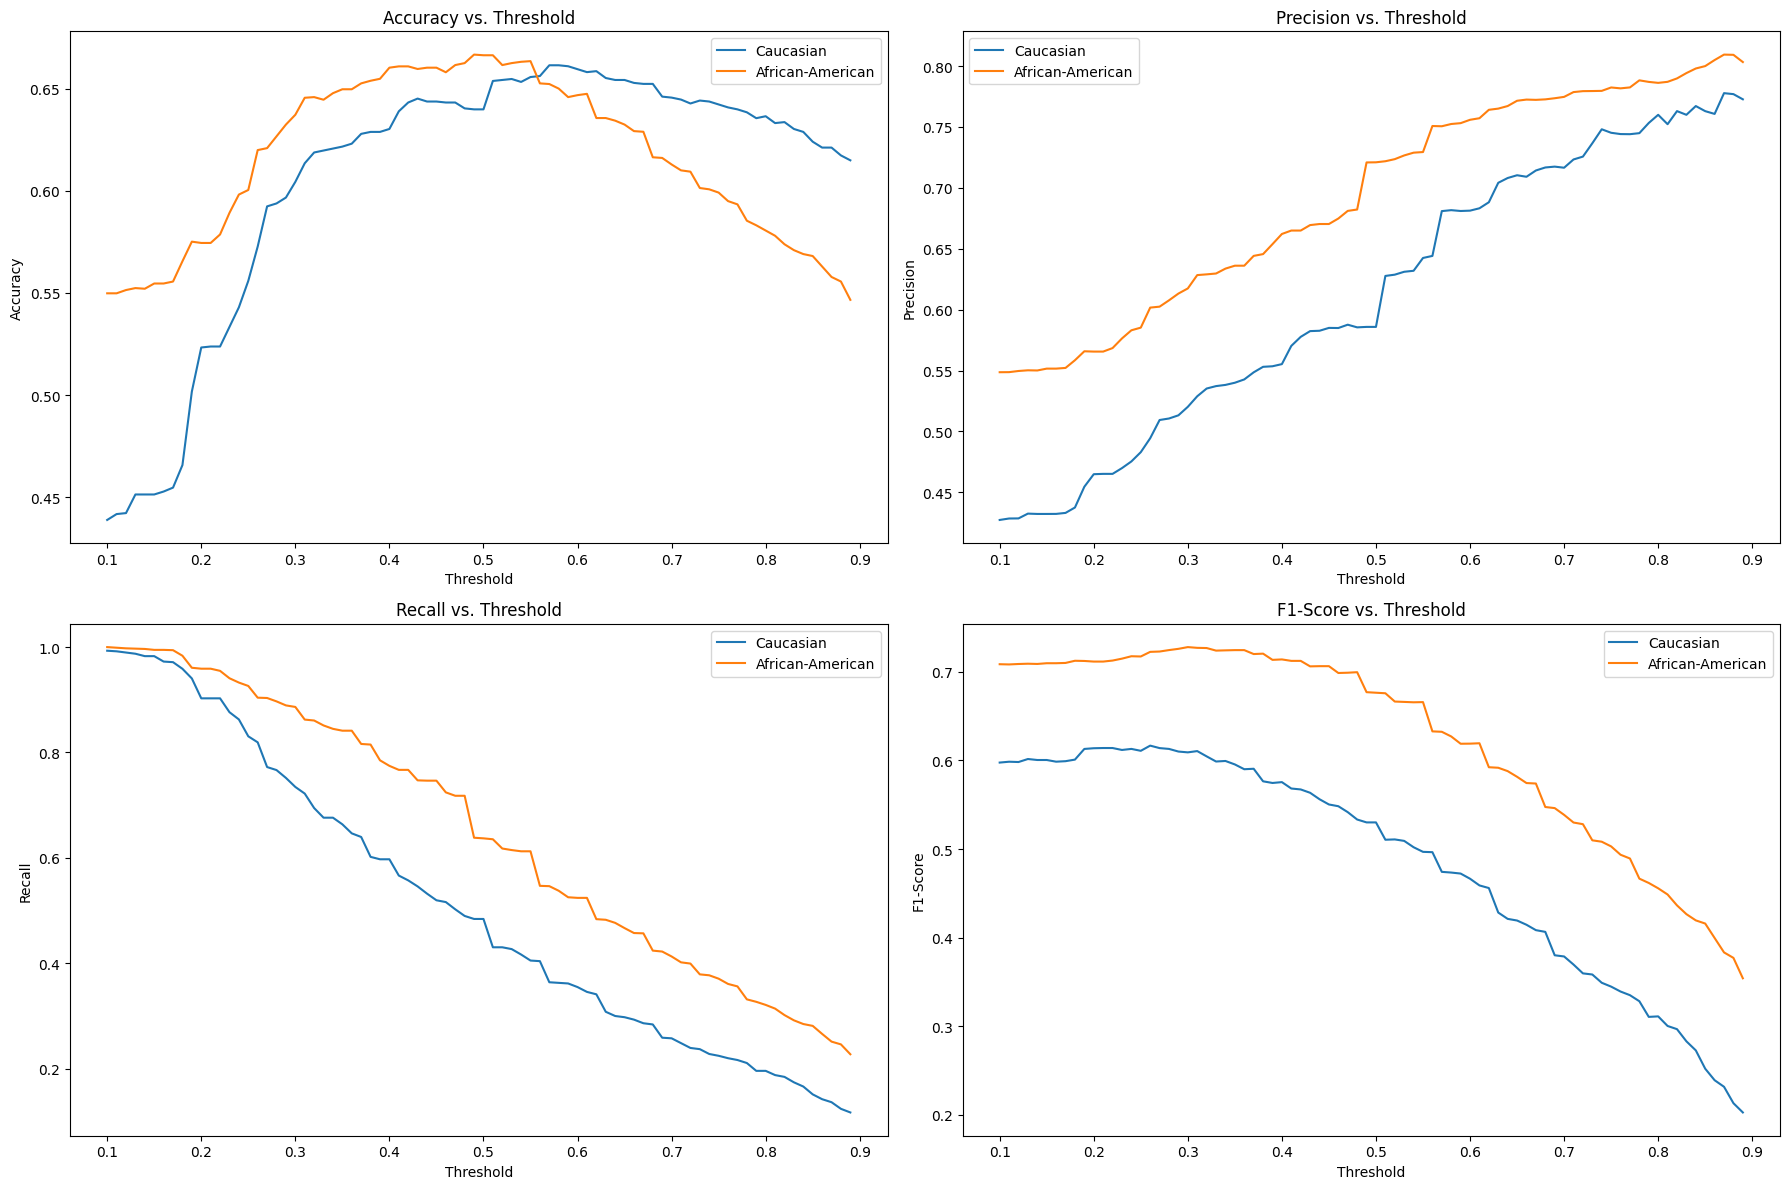

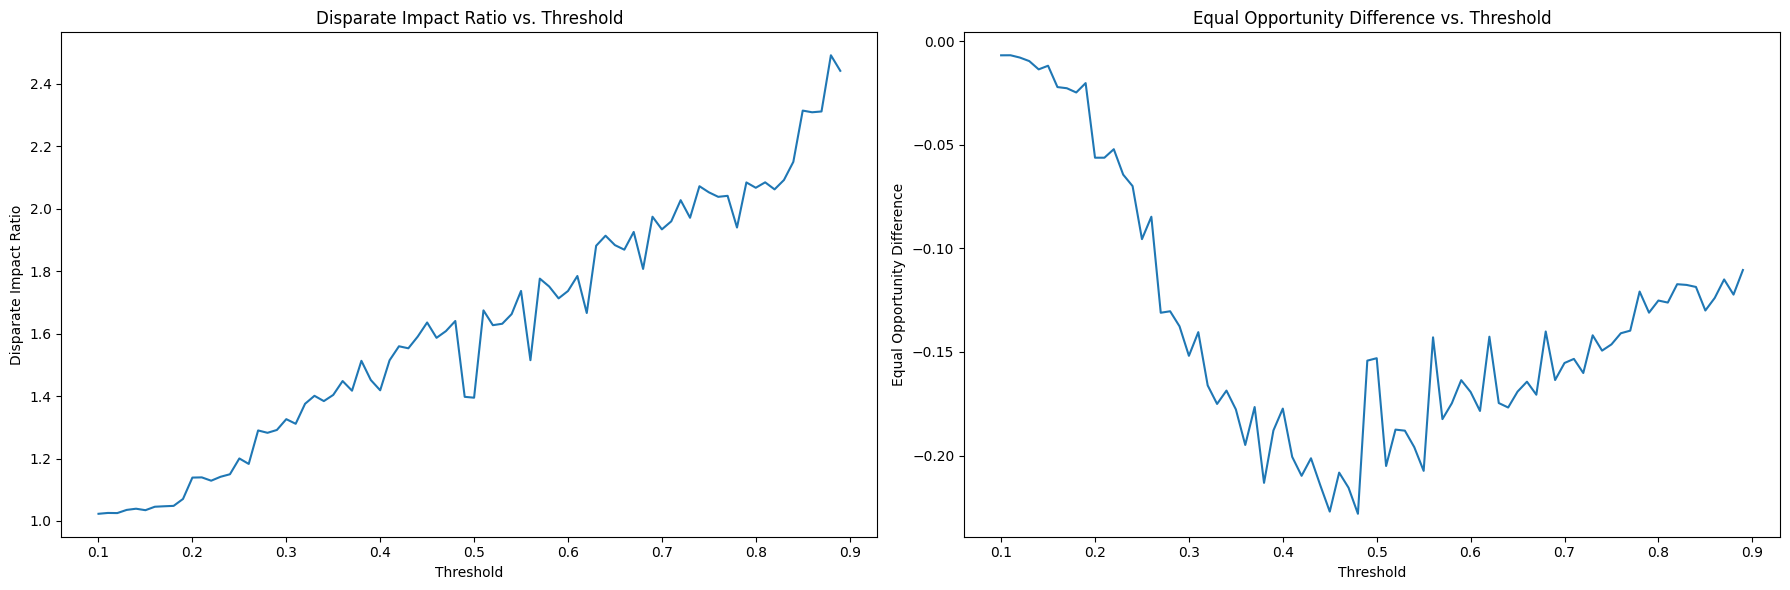

In [7]:
# Define logistic regression classifier
clf = LogisticRegression(random_state=42, max_iter=1000)

# Define races
races = ['Caucasian', 'African-American', 'Asian', 'Hispanic', 'Native American', 'Other']

# Pipeline for logistic regression
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

# Fit the pipeline
pipe.fit(X_train, y_train, classifier__sample_weight=sample_weights)

# Get prediction probabilities
df['pred_prob'] = pipe.predict_proba(X)[:, 1]

# Vary threshold to find the optimal one
thresholds = np.arange(0.1, 0.9, 0.01)

# Initialize lists to store metrics for each threshold
metrics_over_thresholds = {
    'threshold': [],
    'caucasian_accuracy': [],
    'caucasian_precision': [],
    'caucasian_recall': [],
    'caucasian_f1': [],
    'african_american_accuracy': [],
    'african_american_precision': [],
    'african_american_recall': [],
    'african_american_f1': [],
    'disparate_impact_ratio': [],
    'equal_opportunity_difference': []
}

# Dictionary to hold metrics for each threshold
all_metrics = {}

for threshold in thresholds:
    df['pred_baseline'] = (df['pred_prob'] >= threshold).astype(int)
    
    # Calculate metrics for each race
    race_metrics = {}
    for race in races:
        race_data = df[df['race'] == race]
        y_true = race_data['is_recid']
        y_pred = race_data['pred_baseline']
        
        accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)
        
        race_metrics[race] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

        if race == 'Caucasian':
            metrics_over_thresholds['caucasian_accuracy'].append(accuracy)
            metrics_over_thresholds['caucasian_precision'].append(precision)
            metrics_over_thresholds['caucasian_recall'].append(recall)
            metrics_over_thresholds['caucasian_f1'].append(f1)
        elif race == 'African-American':
            metrics_over_thresholds['african_american_accuracy'].append(accuracy)
            metrics_over_thresholds['african_american_precision'].append(precision)
            metrics_over_thresholds['african_american_recall'].append(recall)
            metrics_over_thresholds['african_american_f1'].append(f1)
    
    # Calculate fairness metrics
    privileged_group = 'Caucasian'
    unprivileged_group = 'African-American'
    disparate_impact_ratio, equal_opportunity_difference = calculate_fairness_metrics(df, privileged_group, unprivileged_group, 'is_recid', 'pred_baseline')
    
    metrics_over_thresholds['threshold'].append(threshold)
    metrics_over_thresholds['disparate_impact_ratio'].append(disparate_impact_ratio)
    metrics_over_thresholds['equal_opportunity_difference'].append(equal_opportunity_difference)
    
    race_metrics['fairness_metrics'] = {
        'disparate_impact_ratio': disparate_impact_ratio,
        'equal_opportunity_difference': equal_opportunity_difference
    }
    
    all_metrics[threshold] = race_metrics

# Convert metrics_over_thresholds to a DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics_over_thresholds)

# Plot accuracy, precision, recall, and f1-score vs. threshold
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(metrics_df['threshold'], metrics_df['caucasian_accuracy'], label='Caucasian')
plt.plot(metrics_df['threshold'], metrics_df['african_american_accuracy'], label='African-American')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(metrics_df['threshold'], metrics_df['caucasian_precision'], label='Caucasian')
plt.plot(metrics_df['threshold'], metrics_df['african_american_precision'], label='African-American')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs. Threshold')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(metrics_df['threshold'], metrics_df['caucasian_recall'], label='Caucasian')
plt.plot(metrics_df['threshold'], metrics_df['african_american_recall'], label='African-American')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs. Threshold')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(metrics_df['threshold'], metrics_df['caucasian_f1'], label='Caucasian')
plt.plot(metrics_df['threshold'], metrics_df['african_american_f1'], label='African-American')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Threshold')
plt.legend()

plt.tight_layout()
plt.show()

# Plot disparate impact ratio and equal opportunity difference vs. threshold
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(metrics_df['threshold'], metrics_df['disparate_impact_ratio'])
plt.xlabel('Threshold')
plt.ylabel('Disparate Impact Ratio')
plt.title('Disparate Impact Ratio vs. Threshold')

plt.subplot(1, 2, 2)
plt.plot(metrics_df['threshold'], metrics_df['equal_opportunity_difference'])
plt.xlabel('Threshold')
plt.ylabel('Equal Opportunity Difference')
plt.title('Equal Opportunity Difference vs. Threshold')

plt.tight_layout()
plt.show()

In [8]:
# Define selected thresholds based on visual analysis
selected_thresholds = {
    'Caucasian': 0.3,
    'African-American': 0.25
}

# Apply race-specific thresholds to classify
df['pred_baseline'] = df.apply(lambda row: 1 if row['pred_prob'] >= selected_thresholds.get(row['race'], 0.5) else 0, axis=1)

# Calculate and print the final metrics for Caucasian and African-American groups
interested_races = ['Caucasian', 'African-American']
all_metrics = {}
for race in interested_races:
    race_data = df[df['race'] == race]
    y_true = race_data['is_recid']
    y_pred = race_data['pred_baseline']
    
    accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)
    
    all_metrics[race] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'threshold': selected_thresholds.get(race, 0.5)
    }

# Print the results
for race, metrics in all_metrics.items():
    print(f"Race: {race}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print()


Race: Caucasian
  accuracy: 0.6044
  precision: 0.5203
  recall: 0.7346
  f1_score: 0.6091
  threshold: 0.3000

Race: African-American
  accuracy: 0.6004
  precision: 0.5853
  recall: 0.9262
  f1_score: 0.7173
  threshold: 0.2500



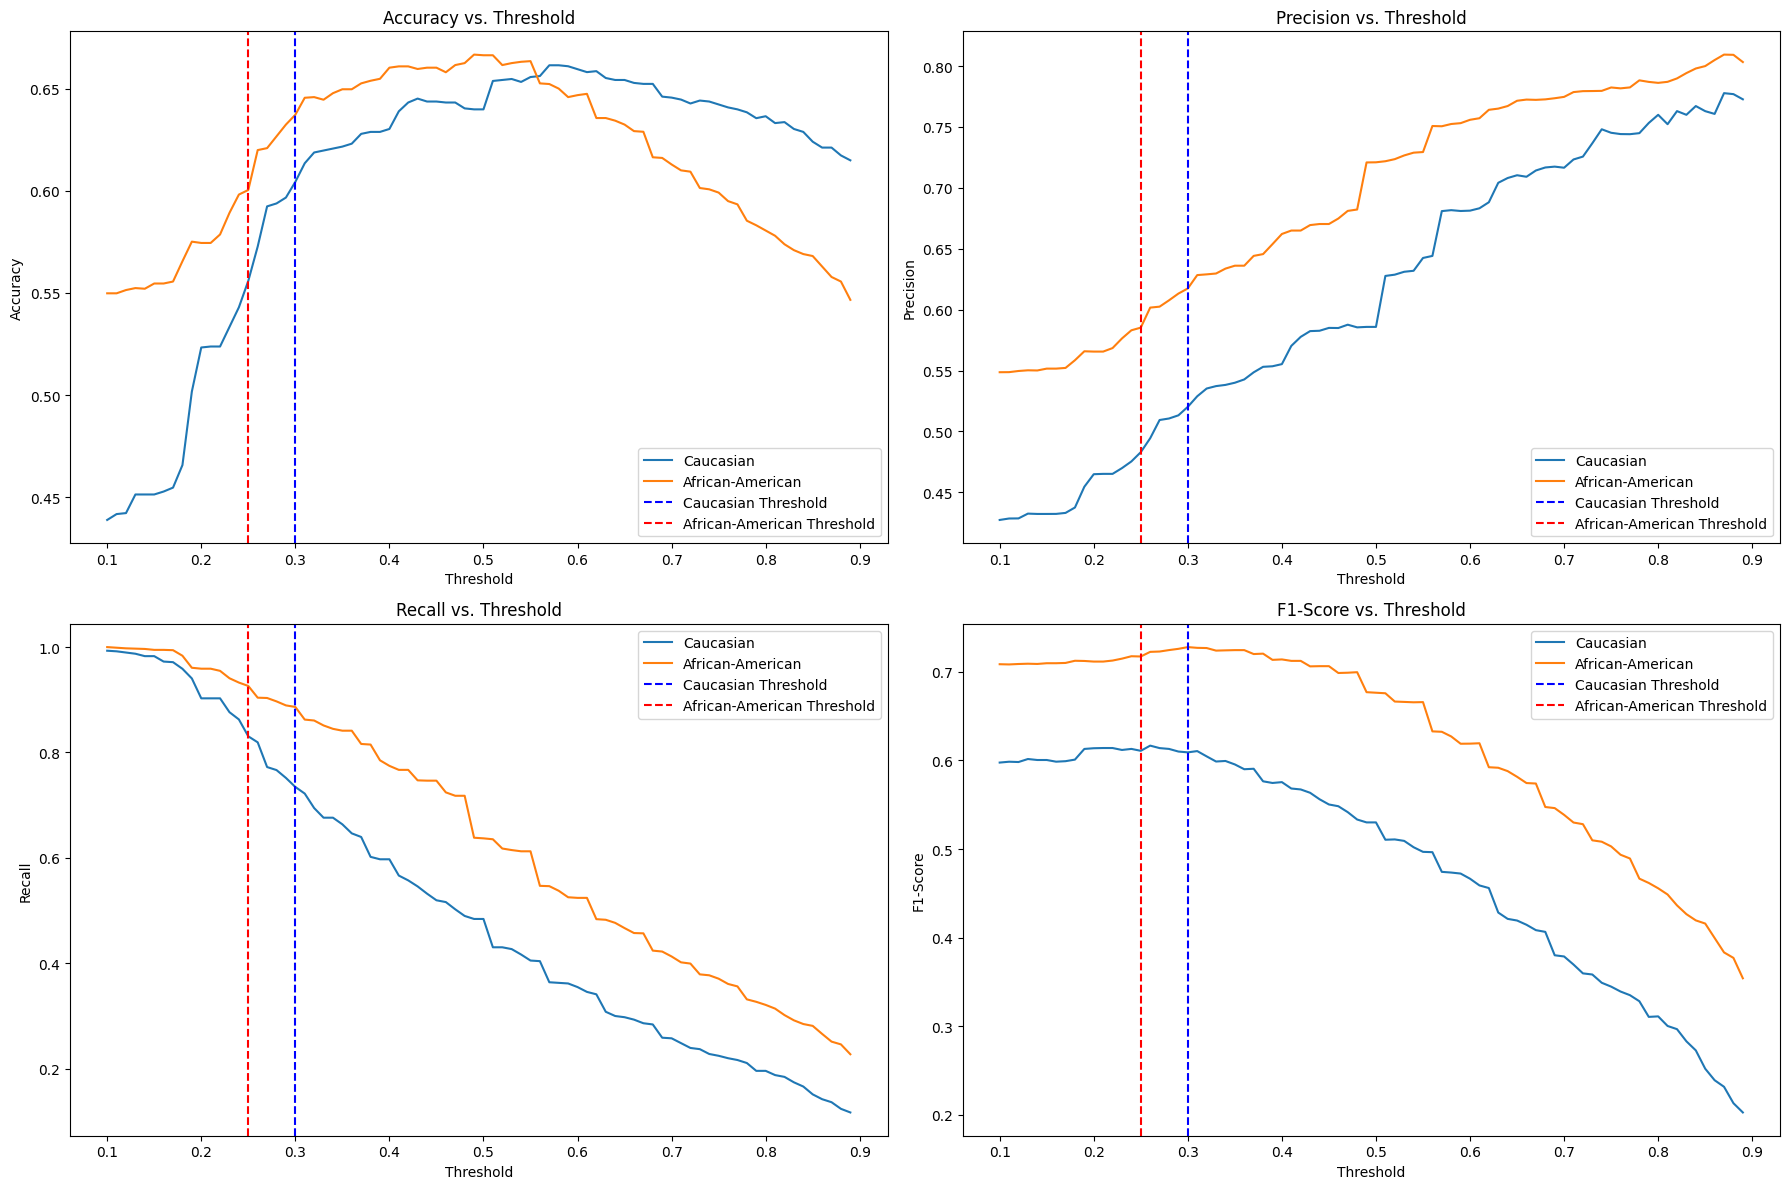

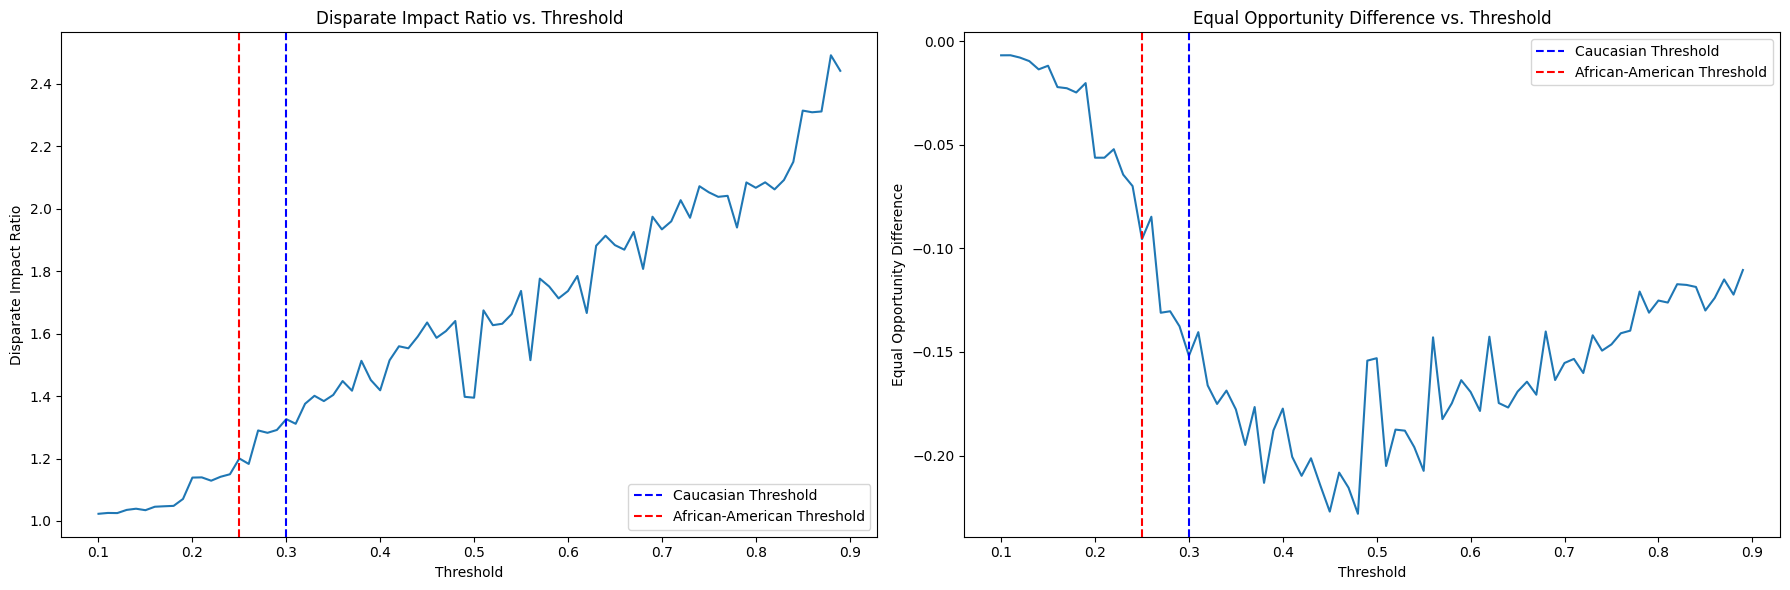

In [9]:
# Define logistic regression classifier
clf = LogisticRegression(random_state=42, max_iter=1000)

# Define races
races = ['Caucasian', 'African-American', 'Asian', 'Hispanic', 'Native American', 'Other']

# Pipeline for logistic regression
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

# Fit the pipeline
pipe.fit(X_train, y_train, classifier__sample_weight=sample_weights)

# Get prediction probabilities
df['pred_prob'] = pipe.predict_proba(X)[:, 1]

# Vary threshold to find the optimal one
thresholds = np.arange(0.1, 0.9, 0.01)

# Initialize lists to store metrics for each threshold
metrics_over_thresholds = {
    'threshold': [],
    'caucasian_accuracy': [],
    'caucasian_precision': [],
    'caucasian_recall': [],
    'caucasian_f1': [],
    'african_american_accuracy': [],
    'african_american_precision': [],
    'african_american_recall': [],
    'african_american_f1': [],
    'disparate_impact_ratio': [],
    'equal_opportunity_difference': []
}

# Dictionary to hold metrics for each threshold
all_metrics = {}

for threshold in thresholds:
    df['pred_baseline'] = (df['pred_prob'] >= threshold).astype(int)
    
    # Calculate metrics for each race
    race_metrics = {}
    for race in races:
        race_data = df[df['race'] == race]
        y_true = race_data['is_recid']
        y_pred = race_data['pred_baseline']
        
        accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)
        
        race_metrics[race] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

        if race == 'Caucasian':
            metrics_over_thresholds['caucasian_accuracy'].append(accuracy)
            metrics_over_thresholds['caucasian_precision'].append(precision)
            metrics_over_thresholds['caucasian_recall'].append(recall)
            metrics_over_thresholds['caucasian_f1'].append(f1)
        elif race == 'African-American':
            metrics_over_thresholds['african_american_accuracy'].append(accuracy)
            metrics_over_thresholds['african_american_precision'].append(precision)
            metrics_over_thresholds['african_american_recall'].append(recall)
            metrics_over_thresholds['african_american_f1'].append(f1)
    
    # Calculate fairness metrics
    privileged_group = 'Caucasian'
    unprivileged_group = 'African-American'
    disparate_impact_ratio, equal_opportunity_difference = calculate_fairness_metrics(df, privileged_group, unprivileged_group, 'is_recid', 'pred_baseline')
    
    metrics_over_thresholds['threshold'].append(threshold)
    metrics_over_thresholds['disparate_impact_ratio'].append(disparate_impact_ratio)
    metrics_over_thresholds['equal_opportunity_difference'].append(equal_opportunity_difference)
    
    race_metrics['fairness_metrics'] = {
        'disparate_impact_ratio': disparate_impact_ratio,
        'equal_opportunity_difference': equal_opportunity_difference
    }
    
    all_metrics[threshold] = race_metrics

# Convert metrics_over_thresholds to a DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics_over_thresholds)

# Define selected thresholds based on visual analysis
selected_thresholds = {
    'Caucasian': 0.3,
    'African-American': 0.25
}

# Plot accuracy, precision, recall, and f1-score vs. threshold
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(metrics_df['threshold'], metrics_df['caucasian_accuracy'], label='Caucasian')
plt.plot(metrics_df['threshold'], metrics_df['african_american_accuracy'], label='African-American')
plt.axvline(x=selected_thresholds['Caucasian'], color='b', linestyle='--', label='Caucasian Threshold')
plt.axvline(x=selected_thresholds['African-American'], color='r', linestyle='--', label='African-American Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(metrics_df['threshold'], metrics_df['caucasian_precision'], label='Caucasian')
plt.plot(metrics_df['threshold'], metrics_df['african_american_precision'], label='African-American')
plt.axvline(x=selected_thresholds['Caucasian'], color='b', linestyle='--', label='Caucasian Threshold')
plt.axvline(x=selected_thresholds['African-American'], color='r', linestyle='--', label='African-American Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs. Threshold')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(metrics_df['threshold'], metrics_df['caucasian_recall'], label='Caucasian')
plt.plot(metrics_df['threshold'], metrics_df['african_american_recall'], label='African-American')
plt.axvline(x=selected_thresholds['Caucasian'], color='b', linestyle='--', label='Caucasian Threshold')
plt.axvline(x=selected_thresholds['African-American'], color='r', linestyle='--', label='African-American Threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs. Threshold')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(metrics_df['threshold'], metrics_df['caucasian_f1'], label='Caucasian')
plt.plot(metrics_df['threshold'], metrics_df['african_american_f1'], label='African-American')
plt.axvline(x=selected_thresholds['Caucasian'], color='b', linestyle='--', label='Caucasian Threshold')
plt.axvline(x=selected_thresholds['African-American'], color='r', linestyle='--', label='African-American Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Threshold')
plt.legend()

plt.tight_layout()
plt.show()

# Plot disparate impact ratio and equal opportunity difference vs. threshold
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(metrics_df['threshold'], metrics_df['disparate_impact_ratio'])
plt.axvline(x=selected_thresholds['Caucasian'], color='b', linestyle='--', label='Caucasian Threshold')
plt.axvline(x=selected_thresholds['African-American'], color='r', linestyle='--', label='African-American Threshold')
plt.xlabel('Threshold')
plt.ylabel('Disparate Impact Ratio')
plt.title('Disparate Impact Ratio vs. Threshold')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics_df['threshold'], metrics_df['equal_opportunity_difference'])
plt.axvline(x=selected_thresholds['Caucasian'], color='b', linestyle='--', label='Caucasian Threshold')
plt.axvline(x=selected_thresholds['African-American'], color='r', linestyle='--', label='African-American Threshold')
plt.xlabel('Threshold')
plt.ylabel('Equal Opportunity Difference')
plt.title('Equal Opportunity Difference vs. Threshold')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Define selected thresholds based on visual analysis
selected_thresholds = {
    'Caucasian': 0.3,
    'African-American': 0.25
}

# Apply race-specific thresholds to classify
df['pred_baseline'] = df.apply(lambda row: 1 if row['pred_prob'] >= selected_thresholds.get(row['race'], 0.5) else 0, axis=1)

# Calculate the final metrics for Caucasian and African-American groups
interested_races = ['Caucasian', 'African-American']
all_metrics = {}
for race in interested_races:
    race_data = df[df['race'] == race]
    y_true = race_data['is_recid']
    y_pred = race_data['pred_baseline']
    
    accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)
    disparate_impact_ratio, equal_opportunity_difference = calculate_fairness_metrics(df, 'Caucasian', 'African-American', 'is_recid', 'pred_baseline')
    
    all_metrics[race] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'disparate_impact_ratio': disparate_impact_ratio,
        'equal_opportunity_difference': equal_opportunity_difference,
        'threshold': selected_thresholds.get(race, 0.5)
    }

# Print the results
for race, metrics in all_metrics.items():
    print(f"Race: {race}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print()

Race: Caucasian
  accuracy: 0.6044
  precision: 0.5203
  recall: 0.7346
  f1_score: 0.6091
  disparate_impact_ratio: 1.4619
  equal_opportunity_difference: -0.1917
  threshold: 0.3000

Race: African-American
  accuracy: 0.6004
  precision: 0.5853
  recall: 0.9262
  f1_score: 0.7173
  disparate_impact_ratio: 1.4619
  equal_opportunity_difference: -0.1917
  threshold: 0.2500



In [11]:
# Define a range of thresholds to test
caucasian_thresholds = np.arange(0.28, 0.33, 0.01)
african_american_thresholds = np.arange(0.22, 0.27, 0.01)

# Initialize a list to store results
results = []

# Loop over each combination of thresholds
for c_thresh in caucasian_thresholds:
    for aa_thresh in african_american_thresholds:
        # Apply race-specific thresholds to classify
        df['pred_baseline'] = df.apply(lambda row: 1 if row['pred_prob'] >= (c_thresh if row['race'] == 'Caucasian' else aa_thresh) else 0, axis=1)
        
        # Calculate metrics for Caucasian
        caucasian_data = df[df['race'] == 'Caucasian']
        y_true_c = caucasian_data['is_recid']
        y_pred_c = caucasian_data['pred_baseline']
        accuracy_c, precision_c, recall_c, f1_c = calculate_metrics(y_true_c, y_pred_c)
        
        # Calculate metrics for African-American
        african_american_data = df[df['race'] == 'African-American']
        y_true_aa = african_american_data['is_recid']
        y_pred_aa = african_american_data['pred_baseline']
        accuracy_aa, precision_aa, recall_aa, f1_aa = calculate_metrics(y_true_aa, y_pred_aa)
        
        # Calculate fairness metrics
        disparate_impact_ratio, equal_opportunity_difference = calculate_fairness_metrics(df, 'Caucasian', 'African-American', 'is_recid', 'pred_baseline')
        
        # Store results
        results.append({
            'caucasian_threshold': c_thresh,
            'african_american_threshold': aa_thresh,
            'caucasian_f1': f1_c,
            'african_american_f1': f1_aa,
            'disparate_impact_ratio': disparate_impact_ratio,
            'equal_opportunity_difference': equal_opportunity_difference
        })

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Print the top 10 results
top_results = results_df.sort_values(by=['caucasian_f1', 'african_american_f1'], ascending=False).head(10)

In [12]:
top_results.style.background_gradient(cmap='viridis')

,caucasian_threshold,african_american_threshold,caucasian_f1,african_american_f1,disparate_impact_ratio,equal_opportunity_difference
5,0.280000,0.270000,0.612992,0.722886,1.302780,-0.136805
4,0.280000,0.260000,0.612992,0.722508,1.305324,-0.137391
2,0.280000,0.240000,0.612992,0.717568,1.389768,-0.166079
3,0.280000,0.250000,0.612992,0.717298,1.375016,-0.159639
1,0.280000,0.230000,0.612992,0.714858,1.418255,-0.174276
0,0.280000,0.220000,0.612992,0.712694,1.459460,-0.188328
23,0.310000,0.270000,0.610547,0.722886,1.432731,-0.181428
22,0.310000,0.260000,0.610547,0.722508,1.435528,-0.182013
20,0.310000,0.240000,0.610547,0.717568,1.528396,-0.210702
21,0.310000,0.250000,0.610547,0.717298,1.512172,-0.204262


## New Pipeline - Race

In [13]:
# Custom threshold classifier
class CustomThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=None, thresholds=None):
        self.base_classifier = base_classifier
        self.thresholds = thresholds if thresholds else {}
    
    def fit(self, X, y, **fit_params):
        self.base_classifier.fit(X, y, **fit_params)
        return self
    
    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)
    
    def predict(self, X, race_column):
        # Get predicted probabilities
        probs = self.predict_proba(X)[:, 1]
        # Apply custom thresholds based on race
        predictions = np.array([
            1 if prob >= self.thresholds.get(race, 0.5) else 0
            for prob, race in zip(probs, race_column)
        ])
        return predictions

# Wrapper class to handle additional arguments in prediction
class PipelineWithCustomPredict(Pipeline):
    def predict(self, X, race_column=None):
        if race_column is None:
            return super().predict(X)
        # Apply the final step's predict method with custom logic
        Xt = X
        for name, transform in self.steps[:-1]:
            Xt = transform.transform(Xt)
        return self.steps[-1][-1].predict(Xt, race_column)

# Feature creation transformer
class FeatureCreation(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.selected_columns = [
            "id", "name", "sex", "dob", "race",
            "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count",
            "c_case_number", "c_charge_degree", "c_charge_desc", "c_offense_date",
            "c_arrest_date", "c_jail_in"
        ]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()
        df['dob'] = pd.to_datetime(df['dob'])
        df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
        df['age_at_arrest'] = (df['c_jail_in'] - df['dob']).dt.days // 365
        age_bins = [0, 24, 34, 44, 54, 100]
        age_labels = ['<25', '25-34', '35-44', '45-54', '55+']
        df['age_group'] = pd.cut(df['age_at_arrest'], bins=age_bins, labels=age_labels, right=False)
        df['c_charge_degree'] = df['c_charge_degree'].str.replace('F', 'Felony')
        df['c_charge_degree'] = df['c_charge_degree'].str.replace('M', 'Misdemeanor')
        df['c_charge_degree'] = df['c_charge_degree'].fillna('Missing')
        df['weights_race'] = compute_sample_weight(class_weight='balanced', y=df['race'])
        df = df.drop(['dob', 'c_case_number', 'c_charge_desc', 'c_offense_date', 'c_arrest_date', 'name', 'c_jail_in', 'age_at_arrest'], axis=1)
        return df

# Assuming df is your DataFrame
df_processed = FeatureCreation().fit_transform(df).set_index('id')

# Split the data into features (X) and target (y)
X = df_processed.drop(columns=['is_recid', 'weights_race'])
y = df_processed['is_recid']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Categorical and numerical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define preprocessing pipelines
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]
)

# Define the base classifier and thresholds
base_classifier = LogisticRegression(random_state=42, max_iter=1000)
thresholds = {
    'Caucasian': 0.26,
    'African-American': 0.30
}

# Create the custom classifier with thresholds
custom_clf = CustomThresholdClassifier(base_classifier=base_classifier, thresholds=thresholds)

# Define the pipeline with the custom classifier
pipe_custom = PipelineWithCustomPredict(steps=[
    ('preprocessor', preprocessor),
    ('classifier', custom_clf)
])

# Fit the pipeline with weights
sample_weights = df_processed.loc[X_train.index, 'weights_race']
pipe_custom.fit(X_train, y_train, classifier__sample_weight=sample_weights)

# Predict with the pipeline, including race column for threshold adjustment
race_column = X_test['race']
predictions = pipe_custom.predict(X_test, race_column=race_column)

# Combine X_test and y_test to ensure target variable is available
X_test_with_target = X_test.copy()
X_test_with_target['is_recid'] = y_test

# Assign predictions back to the DataFrame for evaluation
X_test_with_target['pred_baseline'] = predictions

# Calculate metrics
for race in ['Caucasian', 'African-American']:
    race_data = X_test_with_target[X_test_with_target['race'] == race]
    y_true = race_data['is_recid']
    y_pred = race_data['pred_baseline']
    
    accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)
    
    print(f"Race: {race}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print()

# Calculate and print fairness metrics
privileged_group = 'Caucasian'
unprivileged_group = 'African-American'
disparate_impact_ratio, equal_opportunity_difference = calculate_fairness_metrics(X_test_with_target, privileged_group, unprivileged_group, 'is_recid', 'pred_baseline')

print(f"Disparate Impact Ratio: {disparate_impact_ratio:.4f}")
print(f"Equal Opportunity Difference: {equal_opportunity_difference:.4f}")

Race: Caucasian
  Accuracy: 0.5687
  Precision: 0.4926
  Recall: 0.7528
  F1-Score: 0.5956

Race: African-American
  Accuracy: 0.6463
  Precision: 0.6379
  Recall: 0.8611
  F1-Score: 0.7329

Disparate Impact Ratio: 1.1800
Equal Opportunity Difference: -0.1083


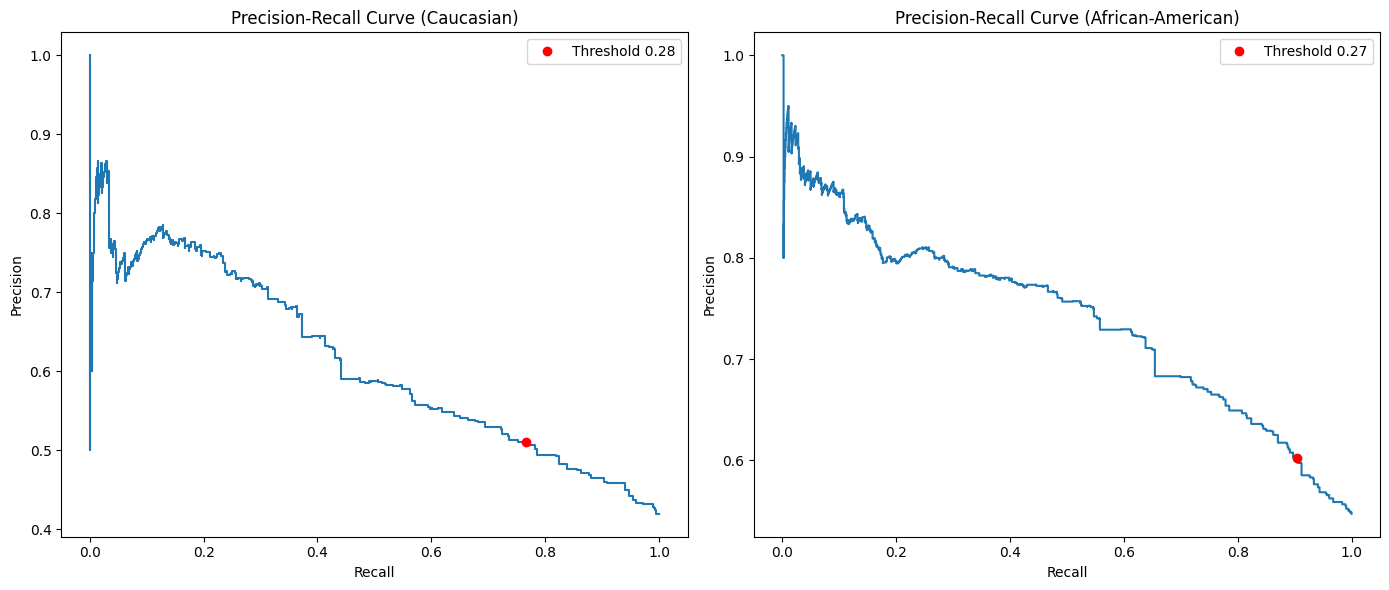

In [14]:
# Define the selected thresholds
selected_thresholds = {
    'Caucasian': 0.28,
    'African-American': 0.27
}

# Apply race-specific thresholds to classify
df['pred_baseline'] = df.apply(lambda row: 1 if row['pred_prob'] >= selected_thresholds.get(row['race'], 0.5) else 0, axis=1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Precision-Recall Curves for Caucasian and African-American groups
for i, race in enumerate(['Caucasian', 'African-American']):
    race_data = df[df['race'] == race]
    y_true = race_data['is_recid']
    y_pred_prob = race_data['pred_prob']
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    display = PrecisionRecallDisplay(precision=precision, recall=recall)
    display.plot(ax=axes[i])
    axes[i].set_title(f'Precision-Recall Curve ({race})')
    
    # Plot the selected threshold
    selected_threshold = selected_thresholds[race]
    threshold_index = (thresholds >= selected_threshold).argmax()
    axes[i].plot(recall[threshold_index], precision[threshold_index], 'ro', label=f'Threshold {selected_threshold}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [15]:
# Define a wider range of thresholds to test
caucasian_thresholds = np.arange(0.2, 0.35, 0.01)
african_american_thresholds = np.arange(0.2, 0.35, 0.01)

# Initialize a list to store results
results = []

# Loop over each combination of thresholds
for c_thresh in caucasian_thresholds:
    for aa_thresh in african_american_thresholds:
        # Apply race-specific thresholds to classify
        df['pred_baseline'] = df.apply(lambda row: 1 if row['pred_prob'] >= (c_thresh if row['race'] == 'Caucasian' else aa_thresh) else 0, axis=1)
        
        # Calculate metrics for Caucasian
        caucasian_data = df[df['race'] == 'Caucasian']
        y_true_c = caucasian_data['is_recid']
        y_pred_c = caucasian_data['pred_baseline']
        accuracy_c, precision_c, recall_c, f1_c = calculate_metrics(y_true_c, y_pred_c)
        
        # Calculate metrics for African-American
        african_american_data = df[df['race'] == 'African-American']
        y_true_aa = african_american_data['is_recid']
        y_pred_aa = african_american_data['pred_baseline']
        accuracy_aa, precision_aa, recall_aa, f1_aa = calculate_metrics(y_true_aa, y_pred_aa)
        
        # Calculate fairness metrics
        disparate_impact_ratio, equal_opportunity_difference = calculate_fairness_metrics(df, 'Caucasian', 'African-American', 'is_recid', 'pred_baseline')
        
        # Store results
        results.append({
            'caucasian_threshold': c_thresh,
            'african_american_threshold': aa_thresh,
            'caucasian_f1': f1_c,
            'african_american_f1': f1_aa,
            'disparate_impact_ratio': disparate_impact_ratio,
            'equal_opportunity_difference': equal_opportunity_difference
        })

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Find the optimal thresholds (example criteria: highest average F1-Score and acceptable fairness metrics)
optimal = results_df.loc[(results_df['disparate_impact_ratio'] >= 0.8) & (results_df['disparate_impact_ratio'] <= 1.25) & 
                         (abs(results_df['equal_opportunity_difference']) <= 0.1)].sort_values(by=['caucasian_f1', 'african_american_f1'], ascending=False).head(1)

In [16]:
optimal.style.background_gradient(cmap='viridis')

,caucasian_threshold,african_american_threshold,caucasian_f1,african_american_f1,disparate_impact_ratio,equal_opportunity_difference
100,0.260000,0.300000,0.616710,0.727885,1.130179,-0.067195


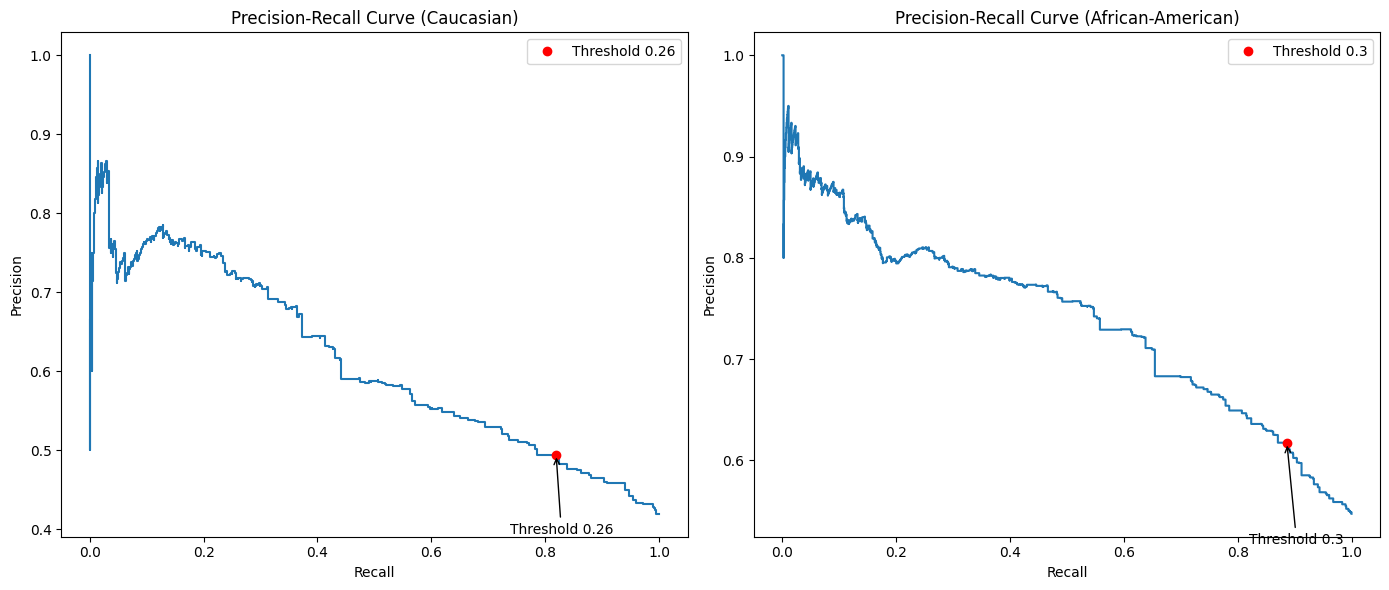

In [17]:
# Define the new selected thresholds
selected_thresholds = {
    'Caucasian': 0.26,
    'African-American': 0.30
}

# Apply race-specific thresholds to classify
df['pred_baseline'] = df.apply(lambda row: 1 if row['pred_prob'] >= selected_thresholds.get(row['race'], 0.5) else 0, axis=1)

# Create subplots for precision-recall curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Precision-Recall Curves for Caucasian and African-American groups
for i, race in enumerate(['Caucasian', 'African-American']):
    race_data = df[df['race'] == race]
    y_true = race_data['is_recid']
    y_pred_prob = race_data['pred_prob']
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    display = PrecisionRecallDisplay(precision=precision, recall=recall)
    display.plot(ax=axes[i])
    axes[i].set_title(f'Precision-Recall Curve ({race})')
    
    # Plot the selected threshold
    selected_threshold = selected_thresholds[race]
    threshold_index = (thresholds >= selected_threshold).argmax()
    axes[i].plot(recall[threshold_index], precision[threshold_index], 'ro', label=f'Threshold {selected_threshold}')
    
    # Add an arrow pointing to the selected threshold
    axes[i].annotate(f'Threshold {selected_threshold}',
                     xy=(recall[threshold_index], precision[threshold_index]),
                     xytext=(recall[threshold_index] + 0.1, precision[threshold_index] - 0.1),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     horizontalalignment='right')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [18]:
# Define the new selected thresholds
selected_thresholds = {
    'Caucasian': 0.26,
    'African-American': 0.30
}

# Apply race-specific thresholds to classify
df['pred_baseline'] = df.apply(lambda row: 1 if row['pred_prob'] >= selected_thresholds.get(row['race'], 0.5) else 0, axis=1)

# Calculate and print the final metrics for Caucasian and African-American groups
interested_races = ['Caucasian', 'African-American']
all_metrics = {}
for race in interested_races:
    race_data = df[df['race'] == race]
    y_true = race_data['is_recid']
    y_pred = race_data['pred_baseline']
    
    accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)
    disparate_impact_ratio, equal_opportunity_difference = calculate_fairness_metrics(df, 'Caucasian', 'African-American', 'is_recid', 'pred_baseline')
    
    all_metrics[race] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'disparate_impact_ratio': disparate_impact_ratio,
        'equal_opportunity_difference': equal_opportunity_difference,
        'threshold': selected_thresholds.get(race, 0.5)
    }

# Print the results
for race, metrics in all_metrics.items():
    print(f"Race: {race}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print()

Race: Caucasian
  accuracy: 0.5727
  precision: 0.4945
  recall: 0.8192
  f1_score: 0.6167
  disparate_impact_ratio: 1.1302
  equal_opportunity_difference: -0.0672
  threshold: 0.2600

Race: African-American
  accuracy: 0.6373
  precision: 0.6175
  recall: 0.8864
  f1_score: 0.7279
  disparate_impact_ratio: 1.1302
  equal_opportunity_difference: -0.0672
  threshold: 0.3000



# Saving new pipeline with adjusted thresholds

In [19]:
pipe_custom

PipelineWithCustomPredict(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['juv_fel_count',
                                                                    'juv_misd_count',
                                                                    'juv_other_count',
                                                                    'priors_count',
                                                                    'pred_prob',
                                                                    'pred_baseline']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   ['sex',
                                                                    'race',
                                                                    'c_charge_degree',
                                                                    'age_group'])])),
                                 ('classifier',
                                  CustomThresholdClassifier(base_classifier=LogisticRegression(max_iter=1000,
                                                                                               random_state=42),
                                                            thresholds={'African-American': 0.3,
                                                                        'Caucasian': 0.26}))])

In [32]:
import os
import pickle
import json

# Pickle the fitted pipeline into a file named pipeline.pickle
with open(os.path.join('..','data', 'pipeline.pickle'), 'wb') as fh:
    pickle.dump(pipe_baseline, fh)


# Serialize the column names from the X DataFrame into a file named columns.json
with open(os.path.join('..','data', 'columns.json'), 'w') as fh:
    json.dump(X.reset_index().columns.tolist(), fh)
    

# Pickle the dtypes of the columns from the X DataFrame into a file named dtypes.pickle
with open(os.path.join('..','data', 'dtypes.pickle'), 'wb') as fh:
    pickle.dump(X.reset_index().dtypes, fh)

In [33]:
# assert that the pipeline is working as expected
# Load the pipeline from the file
with open(os.path.join('..','data', 'pipeline.pickle'), 'rb') as fh:
    loaded_pipe = pickle.load(fh)

# assert that the column names are the same
# Load the column names from the file
with open(os.path.join('..','data', 'columns.json'), 'r') as fh:
    loaded_columns = json.load(fh)

with open(os.path.join('..','data', 'dtypes.pickle'), 'rb') as fh:
    loaded_dtypes = pickle.load(fh)

In [34]:
print(loaded_columns)
print(loaded_dtypes)

['id', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'pred_prob', 'pred_baseline', 'age_group']
id                    int64
sex                  object
race                 object
juv_fel_count         int64
juv_misd_count        int64
juv_other_count       int64
priors_count          int64
c_charge_degree      object
pred_prob           float64
pred_baseline         int64
age_group          category
dtype: object


In [35]:
# predict using the loaded pipeline
y_pred_loaded = loaded_pipe.predict(X_test)

y_pred_loaded

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)